# **Data Analysis on Ischaemic Heart Disease**

## Table of Contents

1. <a href="#toc-01">Overview</a>
2. <a href="#toc-02">Import Dataset and Data Transformation</a>
3. <a href="#toc-03">Exploratory Data Analysis</a>
4. <a href="#toc-04">Model Creation</a>
5. <a href="#toc-05">Model Evaluation</a>
6. <a href="#toc-06">Make Test Predictions</a>
7. <a href="#toc-07">References</a>

## Overview<a id="toc-01"></a>

In 2019, the World Health Organization (WHO) declared that Ischaemic Heart Disease is the leading cause of death worldwide, accounting for 16% of all deaths <sup>[1]</sup>. They also mentioned that annual deaths among men were around 15% more than women <sup>[2]</sup>. 

Hence, we'd like to look at the data for trends/patterns in the death rate for each income group and gender over the last few years (1950-2020). Furthermore, we would like to know the likelihood of a given record falling into a particular age category by developing, training, and testing a model based on data probability using Logistic Regression.

The datasets are taken from the following sources
-	<a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">WHO's interactive platform for mortality data</a>
-	<a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">WHO methods and data sources of country-level causes of death (p. 49)</a>


## Import Dataset and Data Transformation<a id="toc-02"></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['figure.figsize'] = 5,4

Dataset for income grouping was taken from <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">WHO methods and data sources of country-level causes of death (p. 49)</a>. They categorized the countries based from World Bank analytical income of economies.
- High Income
- Upper Middle Income
- Low Middle Income
- Low Income

After reading data from the source, all records with missing data under `income_grouping` are dropped as this category is necessary for data analysis. We retrieved 109 income grouping records with no missing data for each column.

In [4]:
income_grouping_2019 = pd.read_csv('./datasets/World Bank Income Grouping 2019.csv')

income_grouping_2019.dropna(inplace=True)   # Drop all rows with NaN values
income_grouping_2019.reset_index(inplace=True, drop=True)

income_grouping_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   region_code      109 non-null    object
 1   region_name      109 non-null    object
 2   country_code     109 non-null    object
 3   country_name     109 non-null    object
 4   income_grouping  109 non-null    object
dtypes: object(5)
memory usage: 4.4+ KB


Dataset for Ischaemic Heart Disease was taken from <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">WHO's interactive platform for mortality data</a>.

After reading data from the source, the records are filtered by
- <b>Sex</b>: Male and Female only (removing 'Unknown' and 'All')
- <b>Age Group</b>: Remove 'All' and 'Unknown'
- <b>Date Rate per 100,000</b>: Remove records with zero values

We retrieved 130,024 records on Ischaemic Heart Disease with no missing data for each column.

In [5]:
ihd_df = pd.read_csv('./datasets/Ischaemic Heart Disease.csv')

ihd_df_filtered = ihd_df.fillna(0)  # Fill all NaN cells with 0
ihd_df_filtered = ihd_df_filtered.query("sex == ['Male', 'Female'] and age_group != ['[All]', '[Unknown]'] and death_rate_per_100000 != 0")

ihd_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130024 entries, 26 to 296602
Data columns (total 12 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   region_code                                           130024 non-null  object 
 1   region_name                                           130024 non-null  object 
 2   country_code                                          130024 non-null  object 
 3   country_name                                          130024 non-null  object 
 4   year                                                  130024 non-null  int64  
 5   sex                                                   130024 non-null  object 
 6   age_group_code                                        130024 non-null  object 
 7   age_group                                             130024 non-null  object 
 8   num_of_death                               

Merge the necessary fields of Ischeamic Heart Disease and Income Grouping tables.

NOTE: Some of the countries does not have corresponding income grouping. Hence, they we removed from our dataset.

In [6]:
ihd_with_ig_df = ihd_df_filtered[['country_code', 'year', 'sex', 'age_group', 'death_rate_per_100000']].merge(income_grouping_2019[['country_code', 'income_grouping']], on='country_code')

ihd_with_ig_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128634 entries, 0 to 128633
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country_code           128634 non-null  object 
 1   year                   128634 non-null  int64  
 2   sex                    128634 non-null  object 
 3   age_group              128634 non-null  object 
 4   death_rate_per_100000  128634 non-null  float64
 5   income_grouping        128634 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


Rename the age group category based from Statistics Canada's <a href="https://www.statcan.gc.ca/en/concepts/definitions/age2">Age Categories, Life Cycle Groupings</a>
- <b>Children</b>: 00-14 years
- <b>Youth</b>: 15-24 years
- <b>Adults</b>: 25-64 years
- <b>Seniors</b>: 65 years and over

The records for `Youth` and `Children` are combined in this study.

In [7]:
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[0]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[1-4]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[5-9]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[10-14]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[15-19]', 'Children_Youth', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[20-24]', 'Children_Youth', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[25-29]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[30-34]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[35-39]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[40-44]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[45-49]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[50-54]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[55-59]', 'Adults', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[60-64]', 'Adults', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[65-69]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[70-74]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[75-79]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[80-84]', 'Seniors', ihd_with_ig_df['age_group'])
ihd_with_ig_df['age_group'] = np.where(ihd_with_ig_df['age_group'] == '[85+]', 'Seniors', ihd_with_ig_df['age_group'])

ihd_with_ig_df['age_group'].value_counts()

Adults            65769
Seniors           43942
Children_Youth    18923
Name: age_group, dtype: int64

## Exploratory Data Analysis<a id="toc-03"></a>

### Data Analysis on Income Grouping per Year

Group the records by `income_grouping` then display the summary statistics of `death_rate_per_100000` for each `income_grouping`.

NOTE: WHO didn't provide records for `Low Income` grouping. Hence, it is excluded from the study.

In [8]:
ihd_with_ig_grp_income = ihd_with_ig_df.groupby(['income_grouping']) 

ihd_with_ig_grp_income['death_rate_per_100000'].describe()

,count,mean,std,min,25%,50%,75%,max
income_grouping,,,,,,,,
High Income,72034.0,634.031115,1351.363813,0.009323,5.190674,75.471698,599.296719,26000.00000
Low Middle Income,12629.0,840.326820,2079.669397,0.021894,4.356465,49.037783,476.644423,20608.95823
Upper Middle Income,43971.0,490.130301,1178.002267,0.011149,4.866173,62.043170,411.863951,19016.29073


Extract the records for `High Income` category. Group them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [9]:
ihd_with_ig_grpby_high_income = ihd_with_ig_grp_income.get_group('High Income')
ihd_with_ig_grpby_high_income_and_year = ihd_with_ig_grpby_high_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_high_income = ihd_with_ig_grpby_high_income_and_year['year']
death_rate_per_100000_by_high_income = ihd_with_ig_grpby_high_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_high_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Upper Middle Income` category. Group them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [10]:
ihd_with_ig_grpby_upper_middle_income = ihd_with_ig_grp_income.get_group('Upper Middle Income')
ihd_with_ig_grpby_upper_middle_income_and_year = ihd_with_ig_grpby_upper_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['year']
death_rate_per_100000_by_upper_mid_income = ihd_with_ig_grpby_upper_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_upper_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   68 non-null     int64  
 1   death_rate_per_100000  68 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Low Middle Income` category. Group them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [11]:
ihd_with_ig_grpby_low_middle_income = ihd_with_ig_grp_income.get_group('Low Middle Income')
ihd_with_ig_grpby_low_middle_income_and_year = ihd_with_ig_grpby_low_middle_income[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['year']
death_rate_per_100000_by_low_mid_income = ihd_with_ig_grpby_low_middle_income_and_year['death_rate_per_100000']

ihd_with_ig_grpby_low_middle_income_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   57 non-null     int64  
 1   death_rate_per_100000  57 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.0 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each income grouping.

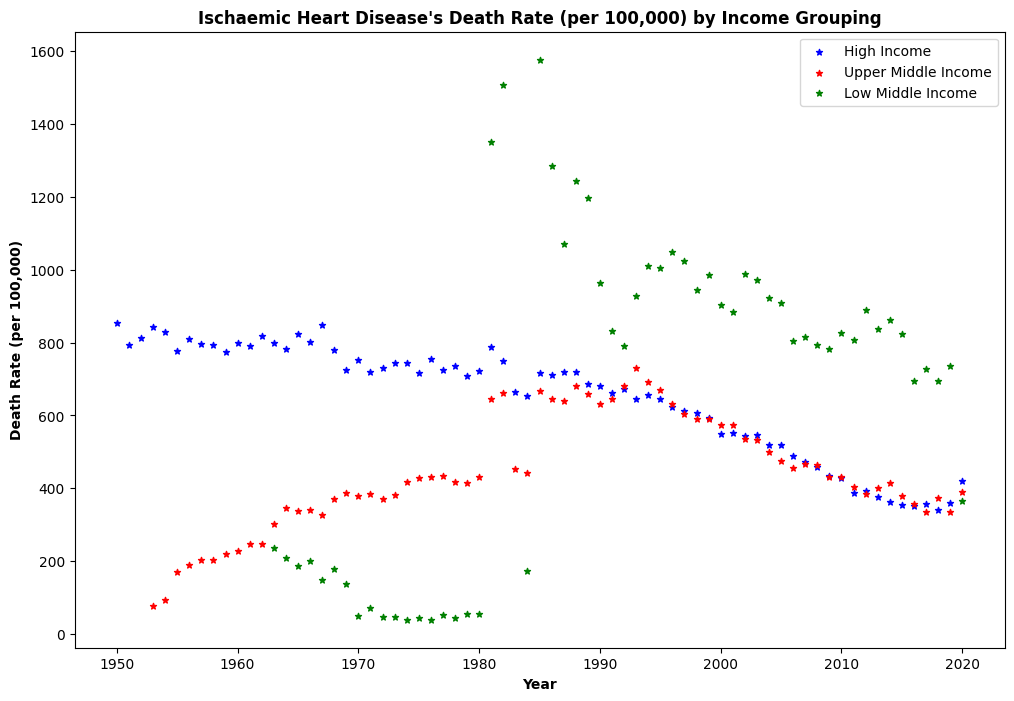

In [12]:
# Plot the graph of Death Rate per 100000 for each Year based on Income Grouping
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Income Grouping", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_high_income, death_rate_per_100000_by_high_income, s=20, c='b', label='High Income', marker='*')
ax.scatter(year_by_upper_mid_income, death_rate_per_100000_by_upper_mid_income, s=20, c='r', label='Upper Middle Income', marker='*')
ax.scatter(year_by_low_mid_income, death_rate_per_100000_by_low_mid_income, s=20, c='g', label='Low Middle Income', marker='*')
ax.legend(loc='upper right')

Based from the results, death rate of Ischaemic Heart Disease under `High Income` is slowly decreasing over the past years. However, the death rate for `Low Middle Income` has <font color="#ff0000">surged in the mid 1980's</font>, doubling the value of `High Income`. There's also an <font color="#ff0000">outlier data for year 2020 under Low Middle Income</font>. We can assume that the data is incomplete for this year.


### Data Analysis on Sex per Year

Group the records by `sex` then display the summary statistics of `death_rate_per_100000` for each `sex`.

In [13]:
ihd_with_ig_grp_sex = ihd_with_ig_df.groupby(['sex']) 

ihd_with_ig_grp_sex['death_rate_per_100000'].describe()  

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,62545.0,514.430051,1285.773049,0.009741,3.423485,39.544638,369.276219,22333.33333
Male,66089.0,690.898283,1476.727641,0.009323,7.458976,107.988981,653.704324,26000.00000


Extract the records for `Male`. Group them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [14]:
df_grpby_male = ihd_with_ig_grp_sex.get_group('Male')
df_grpby_male_and_year = df_grpby_male[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_male = df_grpby_male_and_year['year']
death_rate_per_100000_by_male = df_grpby_male_and_year['death_rate_per_100000']

df_grpby_male_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Extract the records for `Female`. Group them by `year` then get the mean of `death_rate_per_100000` for each year. Create separate dataframe for `year` and `death_rate_per_100000`.

In [15]:
df_grpby_female = ihd_with_ig_grp_sex.get_group('Female')
df_grpby_female_and_year = df_grpby_female[['year', 'death_rate_per_100000']].groupby('year', as_index=False).agg(death_rate_per_100000 = ('death_rate_per_100000', 'mean'))

year_by_female = df_grpby_female_and_year['year']
death_rate_per_100000_by_female = df_grpby_female_and_year['death_rate_per_100000']

df_grpby_female_and_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   71 non-null     int64  
 1   death_rate_per_100000  71 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.2 KB


Plot on the scatterplot the `year` and `death_rate_per_100000` for each sex.

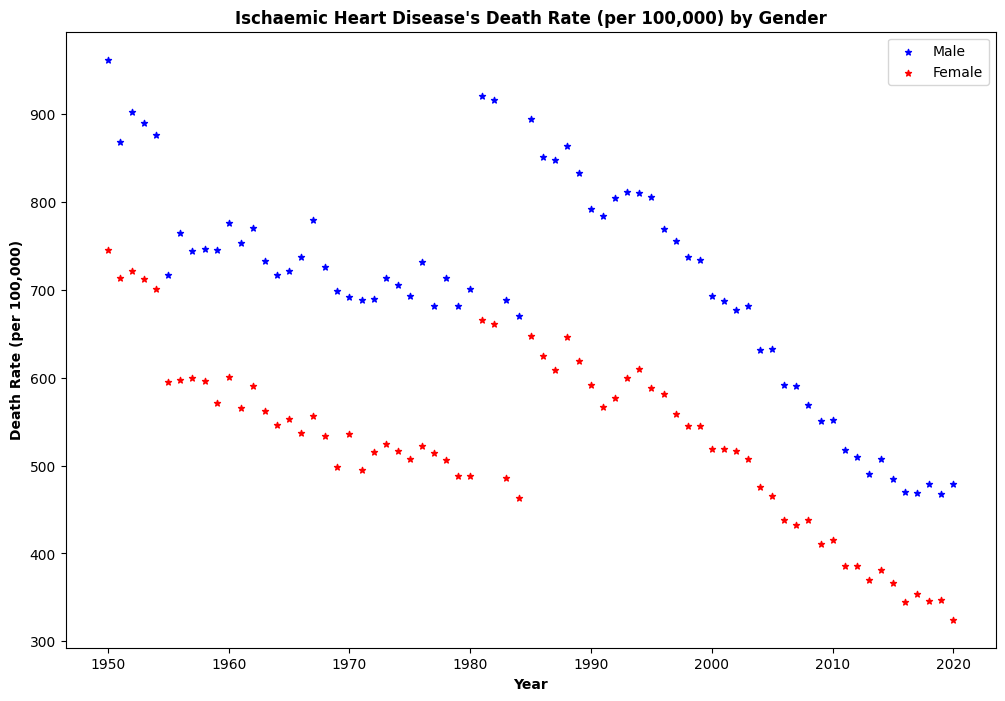

In [16]:
# Plot the graph of Death Rate per 100000 for each Year based on Sex
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel("Year", fontdict={'weight':'bold'})
ax.set_ylabel("Death Rate (per 100,000)", fontdict={'weight':'bold'})
ax.set_title("Ischaemic Heart Disease's Death Rate (per 100,000) by Gender", fontdict={'size':'large', 'weight':'bold'})

ax.scatter(year_by_male, death_rate_per_100000_by_male, s=20, c='b', label='Male', marker='*')
ax.scatter(year_by_female, death_rate_per_100000_by_female, s=20, c='r', label='Female', marker='*')
ax.legend(loc='upper right')

Based from the results, `Male` has a higher death rate on Ischaemic Heart Disease as compared to `Female` though the mortality rate has decreased for both genders over the years. However, <font color="#ff0000">in the mid 1980s, there was a sudden increase of the number of death rates for male and female</font>.

### Dataset Adjustment

As seen from Income Grouping and Sex analysis, there's a sudden increase then decrease of records in the early 1980's. Hence, we will be excluding them from our dataset. That includes year 2020 since the records seem to be incomplete.

In [17]:
# Dataframe of Low Middle Income group
pd.DataFrame(ihd_with_ig_grpby_low_middle_income).query("(year >= 1975 and year <= 1990) or (year == 2020)")['year'].value_counts().sort_index()

1975     68
1976     65
1977     71
1978     67
1979     63
1980     67
1981    213
1982    185
1984     34
1985    189
1986    212
1987    254
1988    220
1989    218
1990    252
2020     30
Name: year, dtype: int64

In [18]:
# Dataframe of Male group
pd.DataFrame(df_grpby_male).query("(year >= 1975 and year <= 1990) or (year == 2020)")['year'].value_counts().sort_index()

1975     783
1976     755
1977     832
1978     764
1979     792
1980     845
1981    1033
1982     988
1983     807
1984     839
1985    1109
1986    1130
1987    1162
1988    1108
1989    1095
1990    1136
2020     322
Name: year, dtype: int64

Only those records from 1985 to 2019 will be used to train and test our model, i.e. removing the outliers that might affect the accuracy and precision of the trained model.

In [19]:
ihd_with_ig_df_filtered = pd.DataFrame(ihd_with_ig_df).query("year >= 1985 and year < 2020")
ihd_with_ig_df_filtered['year'].value_counts().sort_index()

1985    2192
1986    2203
1987    2283
1988    2160
1989    2134
1990    2199
1991    2189
1992    2227
1993    2217
1994    2260
1995    2337
1996    2413
1997    2421
1998    2499
1999    2521
2000    2634
2001    2646
2002    2647
2003    2682
2004    2566
2005    2534
2006    2551
2007    2621
2008    2573
2009    2755
2010    2645
2011    2628
2012    2546
2013    2500
2014    2556
2015    2360
2016    2376
2017    2167
2018    2015
2019    1638
Name: year, dtype: int64

## Model Creation<a id="toc-04"></a>

### Data Preparation: Converting Categorical Features

Check the frequency counts of `income_grouping`, `sex` and `age_group`.

In [20]:
ihd_with_ig_df_filtered['income_grouping'].value_counts()

High Income            41080
Upper Middle Income    31932
Low Middle Income      10883
Name: income_grouping, dtype: int64

In [21]:
ihd_with_ig_df_filtered['sex'].value_counts()

Male      43206
Female    40689
Name: sex, dtype: int64

In [22]:
ihd_with_ig_df_filtered['age_group'].value_counts()

Adults            43592
Seniors           29361
Children_Youth    10942
Name: age_group, dtype: int64

Convert `income_grouping`, `sex` and `age_group` to dummy variables with 0 or 1 as the value.

In [23]:
income_grouping_df = pd.get_dummies(ihd_with_ig_df_filtered['income_grouping'])
income_grouping_df.columns = ['high_income', 'low_middle_income', 'upper_middle_income']
income_grouping_df.head(5)

,high_income,low_middle_income,upper_middle_income
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [24]:
male_gender_df = pd.get_dummies(ihd_with_ig_df_filtered['sex'], drop_first=True)
male_gender_df.columns = ['male_gender']
male_gender_df.head(5)

,male_gender
0,1
1,1
2,1
3,1
4,1


In [25]:
age_grouping_df = pd.get_dummies(ihd_with_ig_df_filtered['age_group'])
age_grouping_df.columns = ['adults', 'children_youth', 'seniors']
age_grouping_df.head(5)

,adults,children_youth,seniors
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


Create a dummy dataframe. Drop `income_grouping`, `sex` and `age_group` and all unnecessary column(s) from the dummy dataframe.

In [26]:
ihd_with_ig_df_dummy = ihd_with_ig_df_filtered.copy()
ihd_with_ig_df_dummy.drop(['country_code', 'sex', 'income_grouping', 'year', 'age_group'], axis=1, inplace=True)

ihd_with_ig_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83895 entries, 0 to 128633
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   death_rate_per_100000  83895 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB


Concatenate in the dummy dataframe the dataframes created for `income_grouping`, `sex` and `age_group` with dummy variables.

In [27]:
ihd_with_ig_df_dummy = pd.concat([ihd_with_ig_df_dummy, male_gender_df, age_grouping_df, income_grouping_df], axis=1, verify_integrity=True)
ihd_with_ig_df_dummy.head(5)

,death_rate_per_100000,male_gender,adults,children_youth,seniors,high_income,low_middle_income,upper_middle_income
0,0.617665,1,0,1,0,0,0,1
1,0.662252,1,0,1,0,0,0,1
2,4.040404,1,1,0,0,0,0,1
3,5.564388,1,1,0,0,0,0,1
4,5.213764,1,1,0,0,0,0,1


Check for independence between columns. The intensity of the feature's dependency is measured by the cell's color (darker color -> more dependency)

<AxesSubplot: >

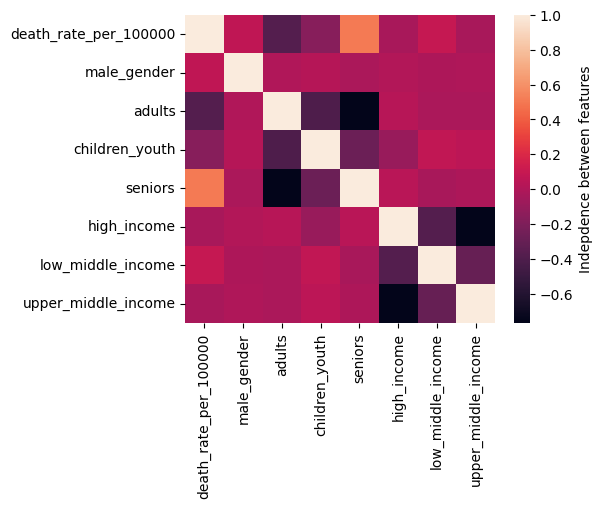

In [28]:
# Check for independence between features
sb.heatmap(ihd_with_ig_df_dummy.corr(), cbar_kws={'label': 'Indepdence between features'})

### Model Creation for Seniors Group

In [29]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['seniors'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train_s.shape} y={y_train_s.shape}")
print(f"No. of test datasets: x={X_test_s.shape} y={y_test_s.shape}\n")

model_seniors = LogisticRegression(solver='lbfgs')
model_seniors.fit(X_train_s, y_train_s)

No. of train datasets: x=(58726, 5) y=(58726,)
No. of test datasets: x=(25169, 5) y=(25169,)



LogisticRegression()

### Model Creation for Adults Group

In [30]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['adults'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train_a.shape} y={y_train_a.shape}")
print(f"No. of test datasets: x={X_test_a.shape} y={y_test_a.shape}\n")

model_adults = LogisticRegression(solver='lbfgs')
model_adults.fit(X_train_a, y_train_a)

No. of train datasets: x=(58726, 5) y=(58726,)
No. of test datasets: x=(25169, 5) y=(25169,)



LogisticRegression()

### Model Creation for Children and Youth Group

In [31]:
X_train_cy, X_test_cy, y_train_cy, y_test_cy = train_test_split(ihd_with_ig_df_dummy.drop(['adults', 'children_youth', 'seniors'], axis=1), age_grouping_df['children_youth'], test_size=0.3, random_state=0)

print(f"No. of train datasets: x={X_train_cy.shape} y={y_train_cy.shape}")
print(f"No. of test datasets: x={X_test_cy.shape} y={y_test_cy.shape}\n")

model_children_youth = LogisticRegression(solver='lbfgs')
model_children_youth.fit(X_train_cy, y_train_cy)

No. of train datasets: x=(58726, 5) y=(58726,)
No. of test datasets: x=(25169, 5) y=(25169,)



LogisticRegression()

## Model Evaluation<a id="toc-05"></a>

### Definition of Terms

**Confusion matrix** is a summary of prediction results on a classification problem.. It gives a clear picture of classification model performance and the types of errors produced by the model. 


Four types of outcomes are possible while evaluating a classification model performance.


* **True Positives (TP)** – the predicted observation belongs to a certain class and that observation actually belongs to that class


* **True Negatives (TN)** – the predicted observation does not belong to a certain class and that observation actually does not belong to that class


* **False Positives (FP)** – the predicted observation belongs to a certain class but that observation actually does not belong to that class. This type of error is called **Type I error.**


* **False Negatives (FN)** – the predicted observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called **Type II error.**


---


**Classification report** is another way to evaluate the classification model performance. It displays the  **precision**, **recall**, **f1** and **support** scores for the model.


* **Precision** - the percentage of correctly predicted positive outcomes out of all the predicted positive outcomes
    
    It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP). Mathematically, precision can be defined as the ratio of `TP to (TP + FP)`. A high precision score means that the model is making fewer false positive predictions. 

* **Recall** - the percentage of correctly predicted positive outcomes out of all the actual positive outcomes
    
    It can be given as the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). Mathematically, recall can be given as the ratio of `TP to (TP + FN)`. A high recall score means that the model is making fewer false negative predictions. 

* **f1-score** - a weighted harmonic mean of precision and recall

    It is a useful metric when you want to balance the trade-off between precision and recall. The f1-score ranges from 0 to 1, with a higher score indicating better performance.


* **Support** - the number of instances of each class in the data
    
    It provides a sense of how well the model is performing across different classes.

In [32]:
def evaluateModel(model, X_test, y_test):

    print(f'Model score: {model.score(X_test, y_test)}')
    print()

    y_pred_test = model.predict(X_test)

    print("Classification Report")
    print(classification_report(y_test, y_pred_test))
    print()

    cm = confusion_matrix(y_test, y_pred_test)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
    sb.heatmap(cm_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')

### Model Evaluation for Seniors Group

The generated model for `Seniors` has an <b>accuracy score of 0.90</b> and a <b>precision score of 0.92</b> which gives us a few false positive predictions.

Model score: 0.9026580317056697

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     16402
           1       0.92      0.79      0.85      8767

    accuracy                           0.90     25169
   macro avg       0.91      0.88      0.89     25169
weighted avg       0.90      0.90      0.90     25169




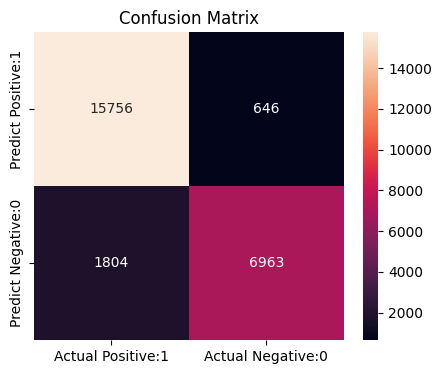

In [33]:
evaluateModel(model_seniors, X_test_s, y_test_s)

### Model Evaluation for Adults Group

The generated model for `Adults` has an <b>accuracy score of 0.77</b> and a <b>precision score of 0.72</b> which gives us a fairly good true positive predictions.

Model score: 0.7733322738289166

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.61      0.72     12068
           1       0.72      0.93      0.81     13101

    accuracy                           0.77     25169
   macro avg       0.80      0.77      0.76     25169
weighted avg       0.80      0.77      0.77     25169




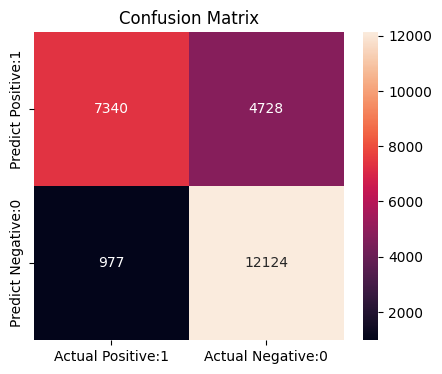

In [34]:
evaluateModel(model_adults, X_test_a, y_test_a)

### Model Evaluation for Children and Youth Group

The generated model for `Children` and `Youth` has an <b>accuracy score of 0.94</b> and a <b>precision score of 0.77</b> which gives us a fairly good true positive predictions.

Model score: 0.9364297349914578

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     21868
           1       0.77      0.74      0.75      3301

    accuracy                           0.94     25169
   macro avg       0.86      0.85      0.86     25169
weighted avg       0.94      0.94      0.94     25169




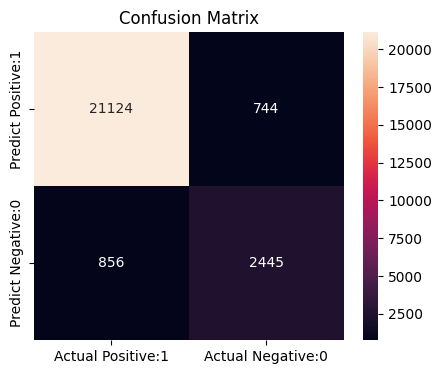

In [35]:
evaluateModel(model_children_youth, X_test_cy, y_test_cy)

## Make Test Prediction<a id="toc-06"></a>

In [36]:
def getPrediction(age_group, model, input):

    df = np.array(input).reshape(1,-1)

    percentage = round(model.predict_proba(df)[0][1] * 100, 2)
    print(f"{str(age_group + ' ').ljust(40, '.')} {percentage}%")


def testPrediction(models: dict, input: list):
    print(f"Gender: {'Male' if input[1] == 1 else 'Female'}")

    income_grouping = None
    if input[2] == 1:
        income_grouping = "High Income"
    elif input[3] == 1:
        income_grouping = "Upper Middle Income"
    elif input[4] == 1:
        income_grouping = "Low Middle Income"

    print(f"Income Grouping: {income_grouping}")
    print(f"Death Rate (per 100,000): {input[0]}")
    print()

    print("Percentage that the record belongs to a specific age group\n")

    for elem in models.items():
        getPrediction(elem[0], elem[1], input)


### Test data #1

Based from percentage report, the record will fall under Seniors group as it gives us <b>95.12%</b>, the highest probability we got for this test data.

In [48]:
date_rate = 700
male_gender = 1
high_income = 0
upper_middle_income = 0
low_middle_income = 1

testPrediction( { 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, 
                [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Male
Income Grouping: Low Middle Income
Death Rate (per 100,000): 700

Percentage that the record belongs to a specific age group

Children/Youth ......................... 0.0%
Adults ................................. 14.38%
Seniors ................................ 95.12%


### Test data #2

Based from percentage report, the record will fall under Adults group as it gives us <b>57.73%</b>, the highest probability we got for this test data.

In [47]:
date_rate = 120
male_gender = 0
high_income = 0
upper_middle_income = 1
low_middle_income = 0

testPrediction( { 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, 
                [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Female
Income Grouping: Upper Middle Income
Death Rate (per 100,000): 120

Percentage that the record belongs to a specific age group

Children/Youth ......................... 0.0%
Adults ................................. 57.73%
Seniors ................................ 10.28%


### Test data #3

Based from percentage report, the record will either fall under Adult group with <b>79.97%</b> or Children and Youth group with <b>55.6%</b> since we got more than 50% probability for both groups.

In [49]:
date_rate = 1
male_gender = 1
high_income = 1
upper_middle_income = 0
low_middle_income = 0

testPrediction( { 'Children/Youth': model_children_youth, 'Adults': model_adults, 'Seniors': model_seniors }, 
                [date_rate, male_gender, high_income, upper_middle_income, low_middle_income])

Gender: Male
Income Grouping: High Income
Death Rate (per 100,000): 1

Percentage that the record belongs to a specific age group

Children/Youth ......................... 55.6%
Adults ................................. 79.97%
Seniors ................................ 2.48%


## References<a id="toc-07"></a>

1. <a href="https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death">https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death</a>
2. <a href="https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates">https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates</a>
3. <a href="https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf">https://www.who.int/docs/default-source/gho-documents/global-health-estimates/ghe2019_cod_methods.pdf</a>
4. <a href="https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease">https://platform.who.int/mortality/themes/theme-details/topics/indicator-groups/indicator-group-details/MDB/ischaemic-heart-disease</a>